In [20]:
import requests
import json
import time
import pickle
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
# import censusdata
from sklearn.metrics.pairwise import haversine_distances
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import math
from bs4 import BeautifulSoup as BS
import ast
from itertools import combinations
from collections import Counter
#from scipy.cluster.hierarchy 
from pyproj import Geod
from shapely.geometry import Point, LineString

%matplotlib inline

In [21]:
hidden = pd.read_pickle('../data/API_key.pkl')
api_key = hidden.loc[0][1]

In [64]:
location = '36.24885, -86.85388' # lat, lng as a string
radius = '4000' # in meters, 20 miles, approximate distance from Davidson center to furthest edge
types = ['gas_station',
         'grocery_or_supermarket',
         'hospital',
         'clothing_store',
        'restaurant'] # select single store type as a test case

In [65]:
# Modified from https://python.gotrained.com/google-places-api-extracting-location-data-reviews/

def search_places_by_coordinate(location, radius, types, api_key, sleep_sec = 2):
    endpoint_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    places = []
    params = {
        'location': location,
        'radius': radius,
        'types': types,
        'key': api_key
    }
    res = requests.get(endpoint_url, params = params)
    results =  res.json()
    places.extend(results['results'])
    time.sleep(sleep_sec)
    while "next_page_token" in results:
        params['pagetoken'] = results['next_page_token'],
        res = requests.get(endpoint_url, params = params)
        results = res.json()
        places.extend(results['results'])
        time.sleep(sleep_sec)
    return places

In [66]:
all_types = search_places_by_coordinate(location, radius, types, api_key)

In [67]:
len(all_types)

6

In [68]:
print(all_types)

[{'business_status': 'OPERATIONAL', 'geometry': {'location': {'lat': 36.2520693, 'lng': -86.8297597}, 'viewport': {'northeast': {'lat': 36.2534926302915, 'lng': -86.8284251697085}, 'southwest': {'lat': 36.2507946697085, 'lng': -86.8311231302915}}}, 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/gas_station-71.png', 'icon_background_color': '#909CE1', 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/gas_pinlet', 'name': 'Shell', 'photos': [{'height': 4128, 'html_attributions': ['<a href="https://maps.google.com/maps/contrib/117265797567492229445">Rooster Davis</a>'], 'photo_reference': 'Aap_uEDwxUyrnSkkC4jtkMM3VxS_xws_r4g671p92EbMHawUNcsN4o7DaDsy_wFG77XXYmq84386nTFUcNmYmgiYj1m50N5KqolAIS1bKo9dnpMWlp_VjMdxAOZiP36fSJVxXWV3bYWXB2XfTe9dUhkGs3aPvXbsx7HJ4Vw-wmVQujlRZFQ4', 'width': 3096}], 'place_id': 'ChIJBQHTXnBeZIgR4BxNPRfisdI', 'plus_code': {'compound_code': '752C+R3 Nashville, TN, USA', 'global_code': '868M752C+R3'}, 'price_level': 2, 'rati

In [56]:
all_types[0]

{'business_status': 'OPERATIONAL',
 'geometry': {'location': {'lat': 36.2520693, 'lng': -86.8297597},
  'viewport': {'northeast': {'lat': 36.2534926302915,
    'lng': -86.8284251697085},
   'southwest': {'lat': 36.2507946697085, 'lng': -86.8311231302915}}},
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/gas_station-71.png',
 'icon_background_color': '#909CE1',
 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/gas_pinlet',
 'name': 'Shell',
 'photos': [{'height': 4128,
   'html_attributions': ['<a href="https://maps.google.com/maps/contrib/117265797567492229445">Rooster Davis</a>'],
   'photo_reference': 'Aap_uEA9uFaPS7y87CD0KqkZCBt1ecvCvpMMPbsXj_YYqtNMKIXmSf2X7QkXpSwG90VY8S6HCPrbMgv6DMpzTnm-ilzBfuPhrIyMrwXf6x6e_c-L3qNelgBsHbah5g-ESqM8ANCWiCZDJPSjsMq1ctr1kZ7OoGdrC29cgXZj8UTrXlWc9Vd2',
   'width': 3096}],
 'place_id': 'ChIJBQHTXnBeZIgR4BxNPRfisdI',
 'plus_code': {'compound_code': '752C+R3 Nashville, TN, USA',
  'global_code': '868M752C+R3

In [76]:
print(all_types[0]['geometry']['location']['lat'])
print(all_types[0]['geometry']['location']['lng'])
print(all_types[0]['name'])
print(all_types[0]['types'][0])

36.2520693
-86.8297597
Shell
gas_station


In [78]:
latitude = []
longitude = []
name = []
types = []

for i in all_types:
    latitude.append(i['geometry']['location']['lat'])
    longitude.append(i['geometry']['location']['lng'])
    name.append(i['name'])
    types.append(i['types'][0])

In [80]:
print(name)

['Shell', "Cenex KCK's", 'Kwik Sak', "Brenda's Corner Market", 'Citgo', 'Friendly Corner Market']


In [83]:
test_df = pd.DataFrame(list(zip(name, types, latitude, longitude)),
               columns =['name', 'type', 'latitude', 'longitude'])

In [84]:
test_df

,name,type,latitude,longitude
0,Shell,gas_station,36.252069,-86.829760
1,Cenex KCK's,gas_station,36.279847,-86.873683
2,Kwik Sak,gas_station,36.218140,-86.836695
3,Brenda's Corner Market,convenience_store,36.280015,-86.873743
4,Citgo,gas_station,36.279806,-86.873688
5,Friendly Corner Market,convenience_store,36.279847,-86.873683


In [12]:
nash_map = folium.Map([36.24885, -86.85388])
for store in gas_stations:
    coords = store['geometry']['location']
    lat = coords['lat']
    lng = coords['lng']
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

In [12]:
davidson_county = gpd.read_file('../data/Davidson County Border (GIS).geojson')
davidson_county.crs = "EPSG:4326"

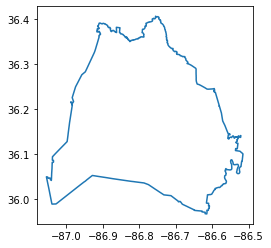

In [13]:
davidson_county.boundary.plot();

In [14]:
xmin,ymin,xmax,ymax =  davidson_county.total_bounds

In [15]:
x_increment = (xmax-xmin)/10
y_increment = (ymax-ymin)/10

In [16]:
# determine boundary locations along x-axis
grid_x_boundaries = [xmin]
new_bound = xmin
for i in range(10):
    new_bound = new_bound + x_increment
    grid_x_boundaries.append(new_bound)

In [17]:
# determine boundary locations along y-axis
grid_y_boundaries = [ymin]
new_bound = ymin
for i in range(10):
    new_bound = new_bound + y_increment
    grid_y_boundaries.append(new_bound)

In [18]:
# get lats and lons in separate lists for center of each grid square
lons = []
lats = []
for left, right in zip(grid_x_boundaries[:-1], grid_x_boundaries[1:]):
    for top, bottom in zip(grid_y_boundaries[:-1], grid_y_boundaries[1:]):
        lats.append((top+bottom)/2)
        lons.append((left+right)/2)

In [19]:
# convery to gpd points
grid_centers = gpd.points_from_xy(lons, lats)

In [20]:
# put into geodataframe
grid_gdf = gpd.GeoDataFrame(geometry = grid_centers, crs = "EPSG:4326")

<AxesSubplot:>

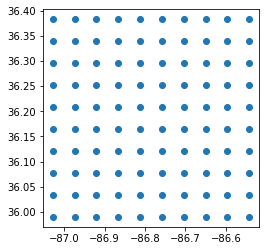

In [21]:
grid_gdf.plot()

C:\Users\16159\AppData\Local\Temp/ipykernel_30876/1592221078.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),


<AxesSubplot:>

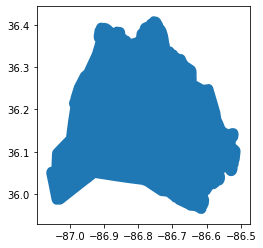

In [22]:
davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer.plot()

In [23]:
# Only keep points within the buffered Davidson county polygon
keep_points = []
for ind, p in grid_gdf['geometry'].iteritems():
    if p.within(davidson_county.loc[0, 'geometry']) or p.within(davidson_county.loc[1, 'geometry']):
        keep_points.append(ind)

grid_points_sub = grid_gdf.loc[keep_points]

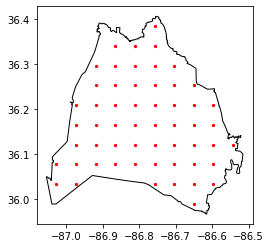

In [24]:
base = davidson_county.plot(color='white', edgecolor='black')

grid_points_sub.plot(ax=base, marker='o', color='red', markersize=5);

In [25]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
def dist_in_meters(point_1, point_2):
    point_1 = [math.radians(l) for l in [point_1.y, point_1.x]]
    point_2 = [math.radians(l) for l in [point_2.y, point_2.x]]
    dist_array_m = haversine_distances([point_1, point_2])*6371000
    return dist_array_m[0][1]

In [26]:
grid_point_radius = dist_in_meters(grid_points_sub.loc[1, 'geometry'], grid_points_sub.loc[2, 'geometry'])

C:\Users\16159\AppData\Local\Temp/ipykernel_30876/3888857068.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),


''

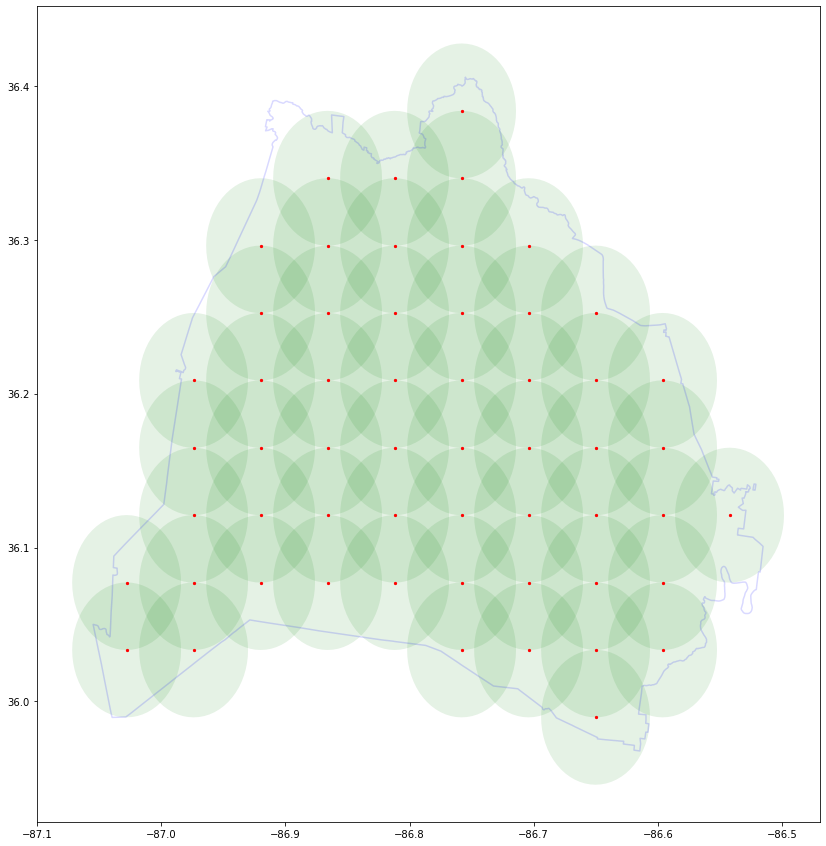

In [31]:
grid_point_radius_mile = 3.0258050367212114828/69
grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),
                                          crs = "EPSG:4326")
f, ax = plt.subplots(1, figsize=(15, 15))
#ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = grid_points_sub_buffers.plot(ax=ax, color = 'green', alpha = 0.1)
grid_points_sub.plot(ax=ax, marker='o', color='red', markersize=5)
;

In [32]:
# creating output list in separate cell in case need to run for loop multiple times because of time out errors
responses = []

In [ ]:
for ind_2, t in enumerate(all_types):
    print(ind_2, t) # just to keep track of progress
    if ind_2 >= 1: # uncomment and tab below over if need to start later in all_types list
        for ind, (lng, lat) in enumerate(list(zip(grid_points_sub['geometry'].x, grid_points_sub['geometry'].y))): # note that lat and lng are switched
        # print(ind, lat, lng) # again, to keep track of progress
        if ind >= 0: # uncomment and tab below if need to start later in grid df
            location = '{}, {}'.format(lat, lng)
            responses.append(search_places_by_coordinate(location, grid_point_radius, t, api_key))